In [81]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import category_encoders as ce
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, Sequential, Dropout
import torch.optim as optim
# pytorch needs data in as a Dataset obj to train and evaluate models
# when dataset is wrapped, it is called DataLoader that parallelly trains the model based on batches
from torch.utils.data import Dataset,DataLoader

import optuna
from optuna.trial import TrialState
import joblib
# not using optuna.visualization direclly due to image rendering issues

In [82]:
EPOCHS = 100
SEED = 42
BATCH = 32

**Problem Statement**

Flux means flow, critical heat flux is that limit beyond which heat can no longer flow from the solid to the liquid. At this point, vapour starts getting formed. Operating the system beyond this limit leads to overheating and failure. Hence predicting this value becomes important.

**Data Visualization Insights**

Output is higher for plate geometries (small length and high D_h)

D_e and D_h impact pressure in a similar way

chf_exp dist. is slightly right-skewed

xeout negatively co-relates to output (-.5)

**Splitting into train and test data**

In [83]:
# Encoding can be done as a part of preprocessing
df = pd.read_csv(r"C:\Users\Dell\Desktop\ML course\CriticalHeatFluxPrediction_Project5\Dataset\FinalDataset.csv")
df

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0
...,...,...,...,...,...,...,...,...,...
1811,Richenderfer,plate,1.01,1500,-0.0218,15.0,120.0,10,9.4
1812,Richenderfer,plate,1.01,1500,-0.0434,15.0,120.0,10,10.4
1813,Richenderfer,plate,1.01,2000,-0.0109,15.0,120.0,10,10.8
1814,Richenderfer,plate,1.01,2000,-0.0218,15.0,120.0,10,10.9


In [84]:
X = df.drop(columns =['chf_exp [MW/m2]'])
y = df['chf_exp [MW/m2]']

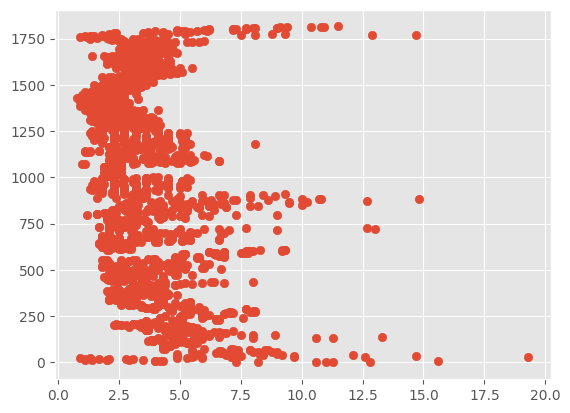

In [85]:
# Understand the distribution of chf
plt.scatter(y, range(len(y)))

In [86]:
encode = ce.OrdinalEncoder()
X_encoded = encode.fit_transform(X)

In [87]:
# shuffling the data is preferred when the samples are ordered before getting split, shuffle is True by default
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size = 0.2, random_state=SEED)

(array([117., 153.,  63.,  23.,   4.,   1.,   2.,   0.,   0.,   1.]),
 array([ 0.9 ,  2.74,  4.58,  6.42,  8.26, 10.1 , 11.94, 13.78, 15.62,
        17.46, 19.3 ]),
 <BarContainer object of 10 artists>)

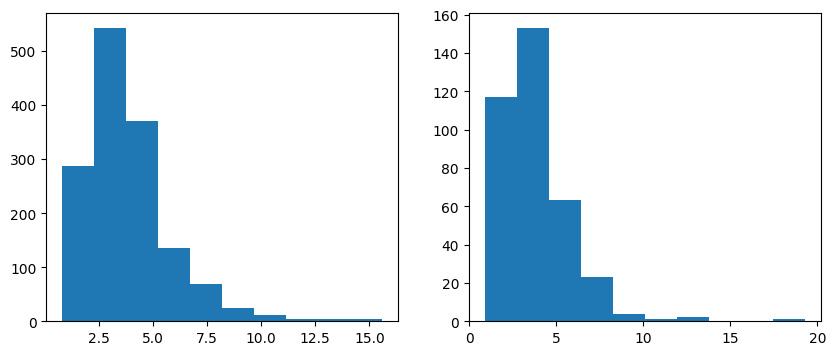

In [10]:
# there are 2 outliers between 14 and 16, ultimately model should be able to predict beyond 15 (in test) as well
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.hist(y_train)

plt.subplot(1,2,2)
plt.hist(y_test)

In [88]:
# Normalizing only the input
X_new_train = normalize(X_train)
X_new_test = normalize(X_test)
print (X_new_train.shape, X_new_test.shape, y_train.shape, y_test.shape)
X_new_train

(1452, 8) (364, 8) (1452,) (364,)


array([[1.65267750e-03, 5.50892499e-04, 3.74056007e-03, ...,
        5.94963899e-03, 5.94963899e-03, 2.37985559e-01],
       [1.41329526e-03, 4.71098420e-04, 3.65336825e-03, ...,
        1.31907558e-03, 3.58034799e-03, 5.02662014e-01],
       [2.34983740e-03, 6.71382115e-04, 2.31291139e-03, ...,
        4.26327643e-03, 1.41997317e-02, 9.20800571e-01],
       ...,
       [6.03112074e-04, 2.01037358e-04, 2.77230517e-03, ...,
        9.44875582e-04, 9.44875582e-04, 6.39298798e-02],
       [2.37701961e-03, 7.92339869e-04, 3.27632536e-03, ...,
        2.21855163e-03, 6.02178301e-03, 8.45426640e-01],
       [1.36241925e-03, 4.54139751e-04, 7.82936930e-03, ...,
        8.62865526e-04, 8.62865526e-04, 3.16081266e-01]])

In [89]:
# tensor is a numpy array that allows backpropagation
# requires_grad = True. Technical: for autograd to record operations on tensor, Simplied: whether trainable or not
# About autograd: it results in a acyclic graph which input tensors as leaves, and output tensors as root. One can calcuate the gradient (of loss func.) from leaf to root.
def convert_to_torch(val):
    return torch.tensor(data = val,dtype = torch.float,requires_grad=True)

In [90]:
# torch in general either takes a df or a single column array, not a series
X_new_train = convert_to_torch(X_new_train)
X_new_test = convert_to_torch(X_new_test)
y_new_train = convert_to_torch(y_train).reshape(-1,1)
y_new_test = convert_to_torch(y_test.to_numpy()).reshape(-1,1)
print (type(y_new_train), y_new_test.shape)

<class 'torch.Tensor'> torch.Size([364, 1])


In [91]:
y_new_train

tensor([[3.6000],
        [2.2000],
        [3.4000],
        ...,
        [6.8000],
        [1.1000],
        [2.1000]], grad_fn=<ViewBackward0>)

In [92]:
# Inherit the Dataset class properties and override getitem and len
# DataLoader needs to know the no. of examples created in the dataset, hence __len__
class FluxDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

In [93]:
train_data = FluxDataset(X_new_train, y_new_train)
test_data = FluxDataset(X_new_test, y_new_test)

In [94]:
# Shuffle for train set, not needed for test
train_loader = DataLoader(train_data,batch_size=BATCH,shuffle=True)
test_loader = DataLoader(test_data,batch_size=BATCH, shuffle = False)

#Size of the loader is the size of train_data/32 as it has been divided into batches
#Benefit: Model trains faster when in batches, hence DataLoader allows us to divide dataset into batches
print (len(train_data), len(train_loader))

1452 46


**Defining the Custom Model, Training and Evaluating it**

In [17]:
class FluxModel(nn.Module):
    def __init__(self, n_features):
        # define all parts of the model
        # Xavier and Kaiming are useful to limit output, for classification but not regression (here)
        super().__init__()
        self.layer1 = Linear(n_features, 24)
        self.act1 = ReLU()
        self.drop1 = Dropout(0.2)
        self.layer2 = Linear(24,12)
        self.act2 = ReLU()
        self.drop2 = Dropout(0.2)
        # self.layer3 = Linear(12,6)
        # self.act3 = ReLU()
        # self.drop3 = Dropout(0.2)
        self.output = Linear(12,1)

    # take a batch of examples x,connect them and return the output
    def forward(self,x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.drop2(x)
        # x = self.layer3(x)
        # x = self.act3(x)
        # x = self.drop3(x)
        x = self.output(x)
        return x

In [18]:
# Define the training function
def train_model (train_dl, model):
    model.train()
    for epochs in range(EPOCHS*3):
        for i, (X,y) in enumerate(train_dl):
            X, y = X.float(), y.float()
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

In [19]:
# Define the eval function
def eval_model (test_dl, model):
    predictions, actuals = [],[]
    model.eval()
    with torch.no_grad():
        for i, (X,y) in enumerate(test_dl):
            X , y = X.float(), y.float()
            y_pred = model(X)
            loss = loss_fn (y_pred, y)
            y_pred = y_pred.detach().numpy()
            predictions.append(y_pred)
            actuals.append(y)
    # vstack creates a stack of each array item row-wise
    predictions , actuals = np.vstack(predictions), np.vstack(actuals)
    
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse, actuals, predictions

In [20]:
# define the prediction function for a single sample row
def pred(samp, model):
    samp = torch.Tensor(samp)
    y_pred = model(samp)
    return y_pred.item()

In [21]:
# Initialize and train the model
model = FluxModel(8)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.001)
train_model(train_loader, model)

Overall rmse is 1.3868948221206665


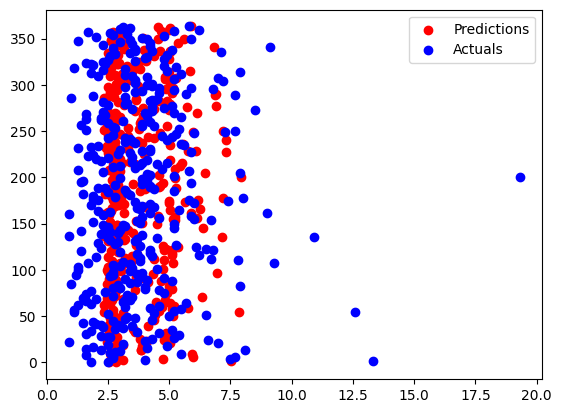

In [22]:
# Evaluate the model
mse, actuals, predictions = eval_model(test_loader, model)
print (f'Overall rmse is {np.sqrt(mse)}')
plt.scatter(predictions, range(len(predictions)), color = 'red')
plt.scatter(actuals, range(len(actuals)), color = 'blue')
plt.legend(['Predictions', 'Actuals'])

#Overall rmse is 1.26600182056427

# Baseline Modeling and Experimentation:
CURRENT: Epochs = 100, dropin at input of 0.2, adam lr = 0.001: rmse = 1.5

- Increase epochs to 200, gave 1.4 and a much better plot
- Epochs to 300, gave 1.3, with a slightly better plot, predicting up to 8
- Increase lr to 0.005, gave 1.31
- adding weight_decay (=L2 penalty) (default 0) of 0.001 (= lr), rmse = 1.33, plot has degraded slightly

## Optuna-based Hyperparameter Tuning ##

In [23]:
# https://blog.paperspace.com/svr-kmeans-clustering-for-regression/

In [96]:
def optuna_model(trial):
    n_features = 8
    n_layers = trial.suggest_int('n_layers', 2, 4)
    layers = []
    for i in range(n_layers):
        o_layer = trial.suggest_int('o_layer {}'.format(i+1),8,24)
        layers.append(Linear(n_features,o_layer))
        layers.append(ReLU())
        p = trial.suggest_float('drop_layer '.format(i+1),0.0,0.2,step = 0.01)
        layers.append(Dropout(p))
        n_features = o_layer

    layers.append(Linear(n_features,1))
    return Sequential(*layers)

In [97]:
def optuna_train_model (trial, train_dl, test_dl, model):
    loss_fn = nn.MSELoss()
    model.train()
    for epochs in range(EPOCHS*3):
        for i, (X,y) in enumerate(train_dl):
            X, y = X.float(), y.float()
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

        predictions, actuals, avg_mse = [],[],0
        model.eval()
        with torch.no_grad():
            for i, (X,y) in enumerate(test_dl):
                X , y = X.float(), y.float()
                y_pred = model(X)
                y_pred = y_pred.detach().numpy()
                predictions.append(y_pred)
                actuals.append(y)
            predictions, actuals = np.vstack(predictions), np.vstack(actuals)
                
        mse = mean_squared_error(actuals, predictions)
        avg_mse = avg_mse + mse
        trial.report(mse,epochs)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return avg_mse/300

In [98]:
def objective(trial):
    model = optuna_model(trial)
    # log = True means logarithmic value
    lr = trial.suggest_float('lr',0.001,0.01, log = True)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    test_mse = optuna_train_model(trial, train_loader, test_loader, model)
    return test_mse

In [101]:
# create_study(sampler = TPESampler) TPESampler is the default for single obj.
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 100, timeout = 600)

[I 2024-06-13 17:46:04,366] A new study created in memory with name: no-name-b16d6875-55b7-4654-9b73-cca2de3f06c2
[I 2024-06-13 17:46:55,809] Trial 0 finished with value: 0.06264270782470703 and parameters: {'n_layers': 3, 'o_layer 1': 13, 'drop_layer ': 0.14, 'o_layer 2': 15, 'o_layer 3': 21, 'lr': 0.001944926907750214}. Best is trial 0 with value: 0.06264270782470703.
[I 2024-06-13 17:47:44,037] Trial 1 finished with value: 0.058500537872314455 and parameters: {'n_layers': 3, 'o_layer 1': 19, 'drop_layer ': 0.03, 'o_layer 2': 15, 'o_layer 3': 20, 'lr': 0.0019311188371259282}. Best is trial 1 with value: 0.058500537872314455.
[I 2024-06-13 17:48:34,544] Trial 2 finished with value: 0.05550024668375651 and parameters: {'n_layers': 2, 'o_layer 1': 21, 'drop_layer ': 0.12, 'o_layer 2': 14, 'lr': 0.00782957488291161}. Best is trial 2 with value: 0.05550024668375651.
[I 2024-06-13 17:49:27,655] Trial 3 finished with value: 0.05949769337972005 and parameters: {'n_layers': 2, 'o_layer 1': 21

In [102]:
pruned_trials = study.get_trials(deepcopy = False, states = [TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy = False, states = [TrialState.COMPLETE])

print ('Study statistics')
print (f'No of total trials is {len(study.trials)}')
print (f'Pruned trials are {len(pruned_trials)} and Completed trials are {len(complete_trials)}')
print(f'The best trial gives an with rmse of {np.sqrt(study.best_trial.value)}')
print (f'The best parameter values are:')
for key, value in study.best_trial.params.items():
    print (f'{key}: {value}')

Study statistics
No of total trials is 38
Pruned trials are 25 and Completed trials are 13
The best trial gives an with rmse of 0.22594775052206886
The best parameter values are:
n_layers: 3
o_layer 1: 20
drop_layer : 0.06
o_layer 2: 10
o_layer 3: 15
lr: 0.0030605205245855904


**Build the model with tuned values**

In [103]:
class BestModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer1 = Linear(n_features, 20)
        self.act1 = ReLU()
        self.drop1 = Dropout(0.06)
        self.layer2 = Linear(20,10)
        self.act2 = ReLU()
        self.layer3 = Linear(10,15)
        self.act3 = ReLU()
        self.output = Linear(15,1)

    def forward(self,x):
        x = self.layer1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.layer2(x)
        x = self.act2(x)
        # x = self.drop2(x)
        x = self.layer3(x)
        x = self.act3(x)
        # x = self.drop3(x)
        x = self.output(x)
        return x

In [104]:
model = BestModel(8)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0031)
train_model(train_loader, model)

Overall rmse is 1.2273732423782349


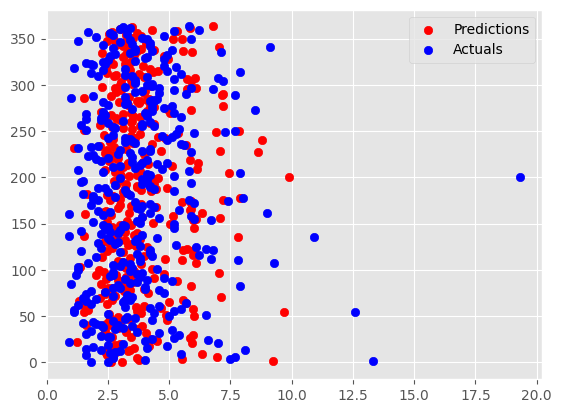

In [105]:
mse, actuals, predictions = eval_model(test_loader, model)
print (f'Overall rmse is {np.sqrt(mse)}')
plt.scatter(predictions, range(len(predictions)), color = 'red')
plt.scatter(actuals, range(len(actuals)), color = 'blue')
plt.legend(['Predictions', 'Actuals'])

In [106]:
# Predicting over a sample
print (f'Overall rmse is {np.sqrt(mse)}')
pred_mse = pred([3.5722e-03, 8.9305e-04, 4.9252e-03, 3.0319e-01, 9.9352e-05, 2.2326e-03,
        5.9388e-03, 9.5289e-01],model)
print (f'rmse of the sample is {np.sqrt(pred_mse)}')

Overall rmse is 1.2273732423782349
rmse of the sample is 1.1110396991404496


**Optuna Visualizations**

C:\Users\Dell\AppData\Local\Temp\ipykernel_19316\1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

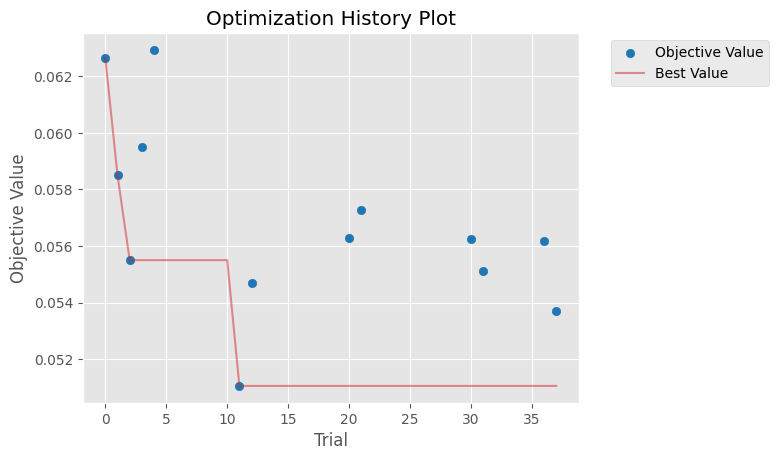

In [107]:
optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\Dell\AppData\Local\Temp\ipykernel_19316\2082283104.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["o_layer 2"])


<Axes: title={'center': 'Parallel Coordinate Plot'}>

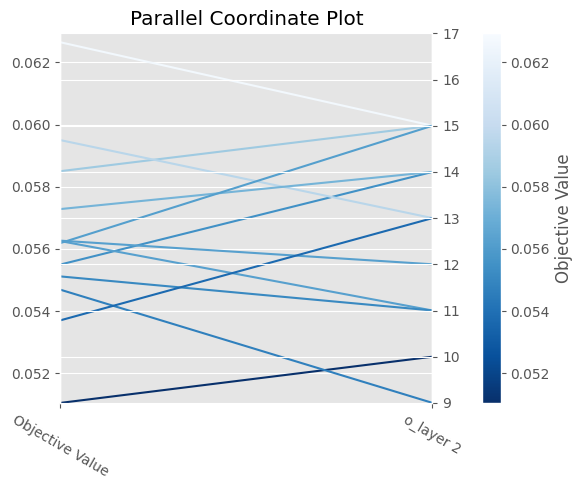

In [108]:
# based on the plot, Adam has performed the best with decreasing objective values
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["o_layer 2"])

C:\Users\Dell\AppData\Local\Temp\ipykernel_19316\1678582933.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["o_layer 3"])


<Axes: title={'center': 'Parallel Coordinate Plot'}>

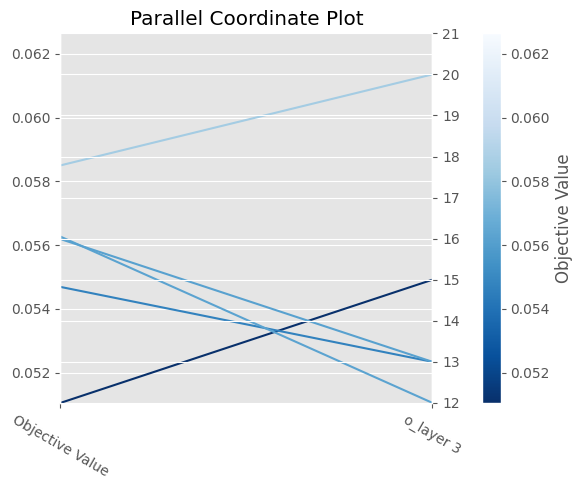

In [109]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["o_layer 3"])

C:\Users\Dell\AppData\Local\Temp\ipykernel_19316\2937014235.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["n_layers"])


<Axes: title={'center': 'Parallel Coordinate Plot'}>

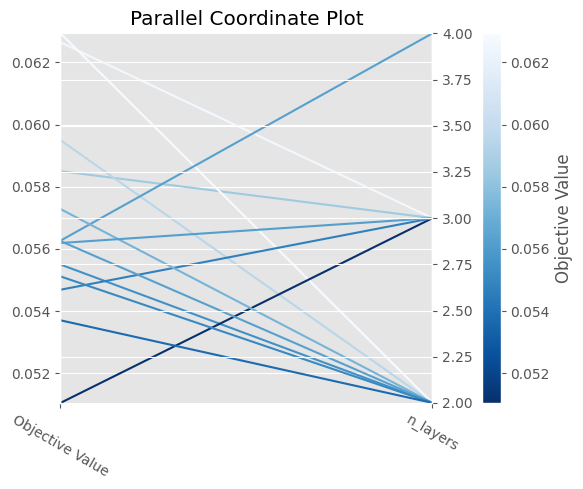

In [110]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["n_layers"])

C:\Users\Dell\AppData\Local\Temp\ipykernel_19316\2375574420.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
c:\Users\Dell\Desktop\ML course\torchenv\Lib\site-packages\optuna\visualization\matplotlib\_slice.py:162: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim[0], xlim[1])


array([<Axes: xlabel='drop_layer ', ylabel='Objective Value'>,
       <Axes: xlabel='lr'>, <Axes: xlabel='n_layers'>,
       <Axes: xlabel='o_layer 1'>, <Axes: xlabel='o_layer 2'>,
       <Axes: xlabel='o_layer 3'>, <Axes: xlabel='o_layer 4'>],
      dtype=object)

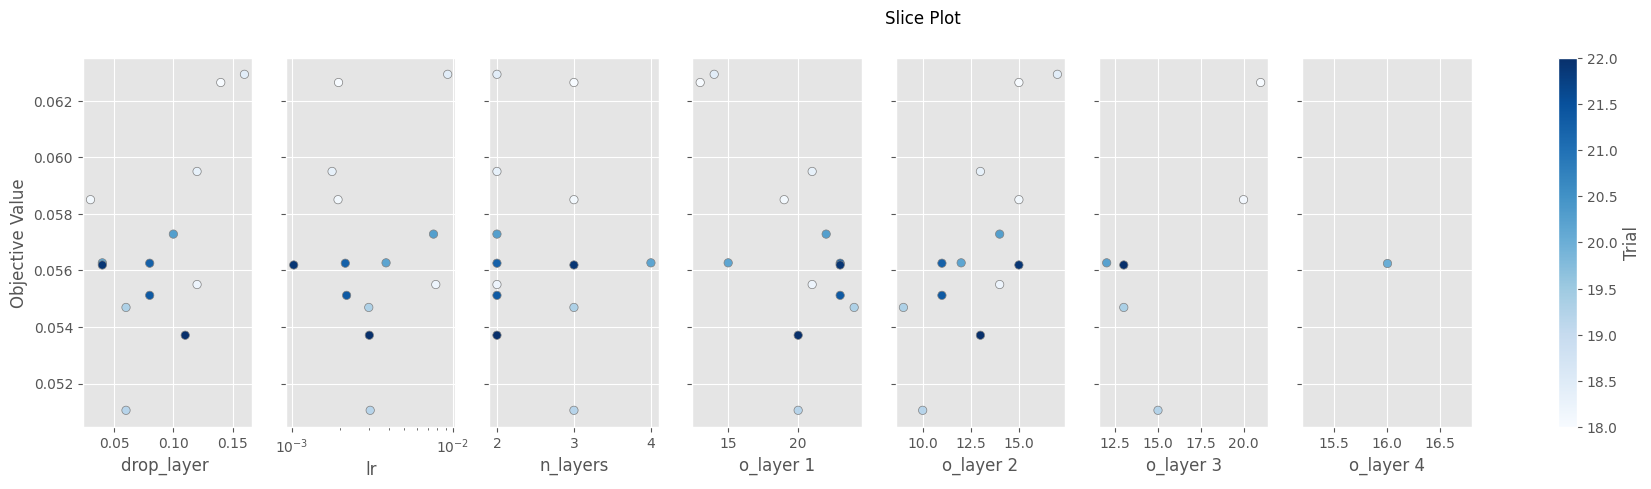

In [111]:
optuna.visualization.matplotlib.plot_slice(study)

C:\Users\Dell\AppData\Local\Temp\ipykernel_19316\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

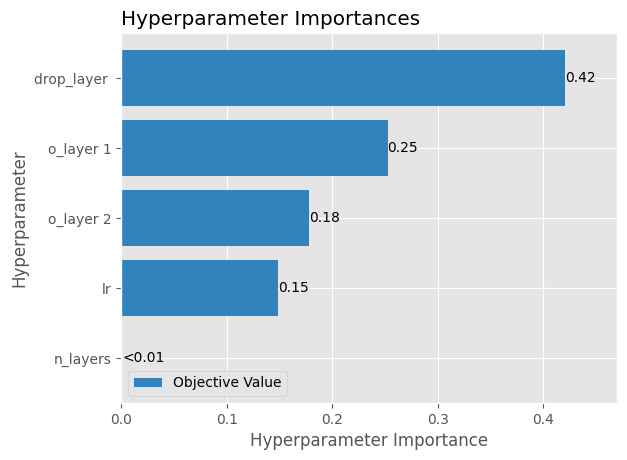

In [112]:
optuna.visualization.matplotlib.plot_param_importances(study)

## Saving the Model ##

In [113]:
torch.save(model.state_dict(),r'C:\Users\Dell\Desktop\ML course\CriticalHeatFluxPrediction_Project5\Model\TorchModel.pt')

In [114]:
model_state = torch.load(r'C:\Users\Dell\Desktop\ML course\CriticalHeatFluxPrediction_Project5\Model\TorchModel.pt')
model_state

OrderedDict([('layer1.weight',
              tensor([[ 3.3474e+00,  2.4702e+00,  9.1305e+00, -7.1757e-03,  2.2529e+01,
                       -6.6492e-01,  9.2556e-01,  1.7793e-01],
                      [ 4.0507e-02,  1.9204e-02, -1.9133e-01, -2.4420e-01,  3.0253e-02,
                        1.5634e-01, -2.7848e-01,  1.5470e-01],
                      [-1.9502e-01, -1.6481e-03, -3.2585e-01, -1.8524e-01,  2.6164e-01,
                       -3.1339e-01, -6.4340e-03, -1.6545e-01],
                      [-3.9581e+00, -3.4815e+00, -4.0109e+00,  3.2364e-01, -2.6199e+01,
                       -3.4085e-01, -4.5706e-01, -2.5757e+00],
                      [-1.4275e+00, -9.4565e-01, -3.8953e+00,  1.0058e-01, -3.2316e+01,
                        2.1121e+00,  3.7507e-01, -1.0613e+00],
                      [-1.1810e-01,  1.0781e-01,  8.9626e-02, -3.0696e-01,  2.8354e-01,
                       -7.3572e-02, -7.6922e-02,  4.7001e-02],
                      [-1.5119e+00, -1.3198e+00, -5.4498e+00,  

In [115]:
new_model = BestModel(8)

In [116]:
new_model.load_state_dict(model_state)

<All keys matched successfully>

In [117]:
new_model

BestModel(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.06, inplace=False)
  (layer2): Linear(in_features=20, out_features=10, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=10, out_features=15, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=15, out_features=1, bias=True)
)

## Testing with inputs from Streamlit UI ##

In [118]:
new_model(X_new_test[0]).item()

2.561490535736084

In [119]:
data = np.array([1,1,0.10,0,-0.87,1.00,1,10])

In [120]:
samp = torch.tensor(data,dtype=torch.float,requires_grad=True)
samp

tensor([ 1.0000,  1.0000,  0.1000,  0.0000, -0.8700,  1.0000,  1.0000, 10.0000],
       requires_grad=True)

In [121]:
str(model(samp).item())

'387.8489074707031'